In [110]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tools.ImageOperate import hist_cut, hist_remap, clahe_equalize, pyrdown, pyrdown_multithread
from location.LineCluster import find_barcode_by_cluster

Function pyrdown_multithread took 2.369ms to run
(322, 584, 3)


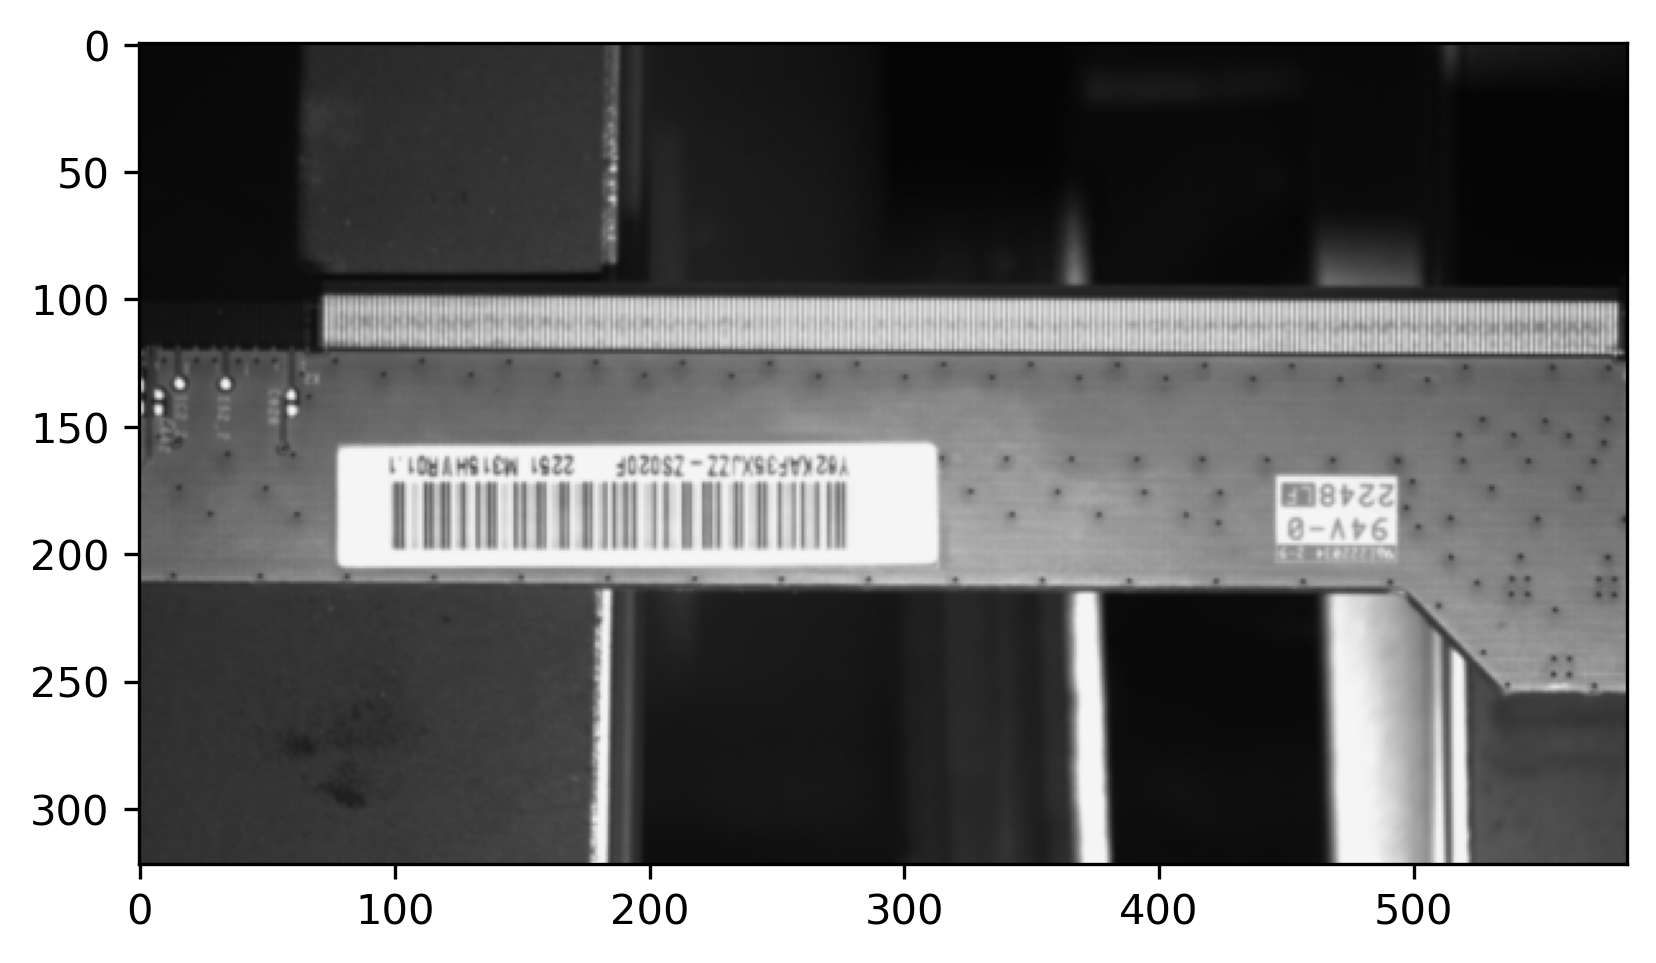

In [111]:
file = r"D:\Fenkx\Fenkx - General\AI\Dataset\BarCode\My Datasets\Factory\1216121041_NG_BarCode_Camera3_1216121042.jpg"
image_source = cv2.imdecode(np.fromfile(file, dtype=np.uint8), 1)
image_pydown = pyrdown_multithread(image_source)
print(image_pydown[-1].shape)
plt.figure(dpi=300)
# plt.subplot(2, 1, 1)
plt.imshow(image_pydown[-1])
# plt.subplot(2, 1, 2)
# plt.hist(image_pydown[-1].ravel(), np.max(image_pydown[-1]), [0, np.max(image_pydown[-1])])
plt.show()

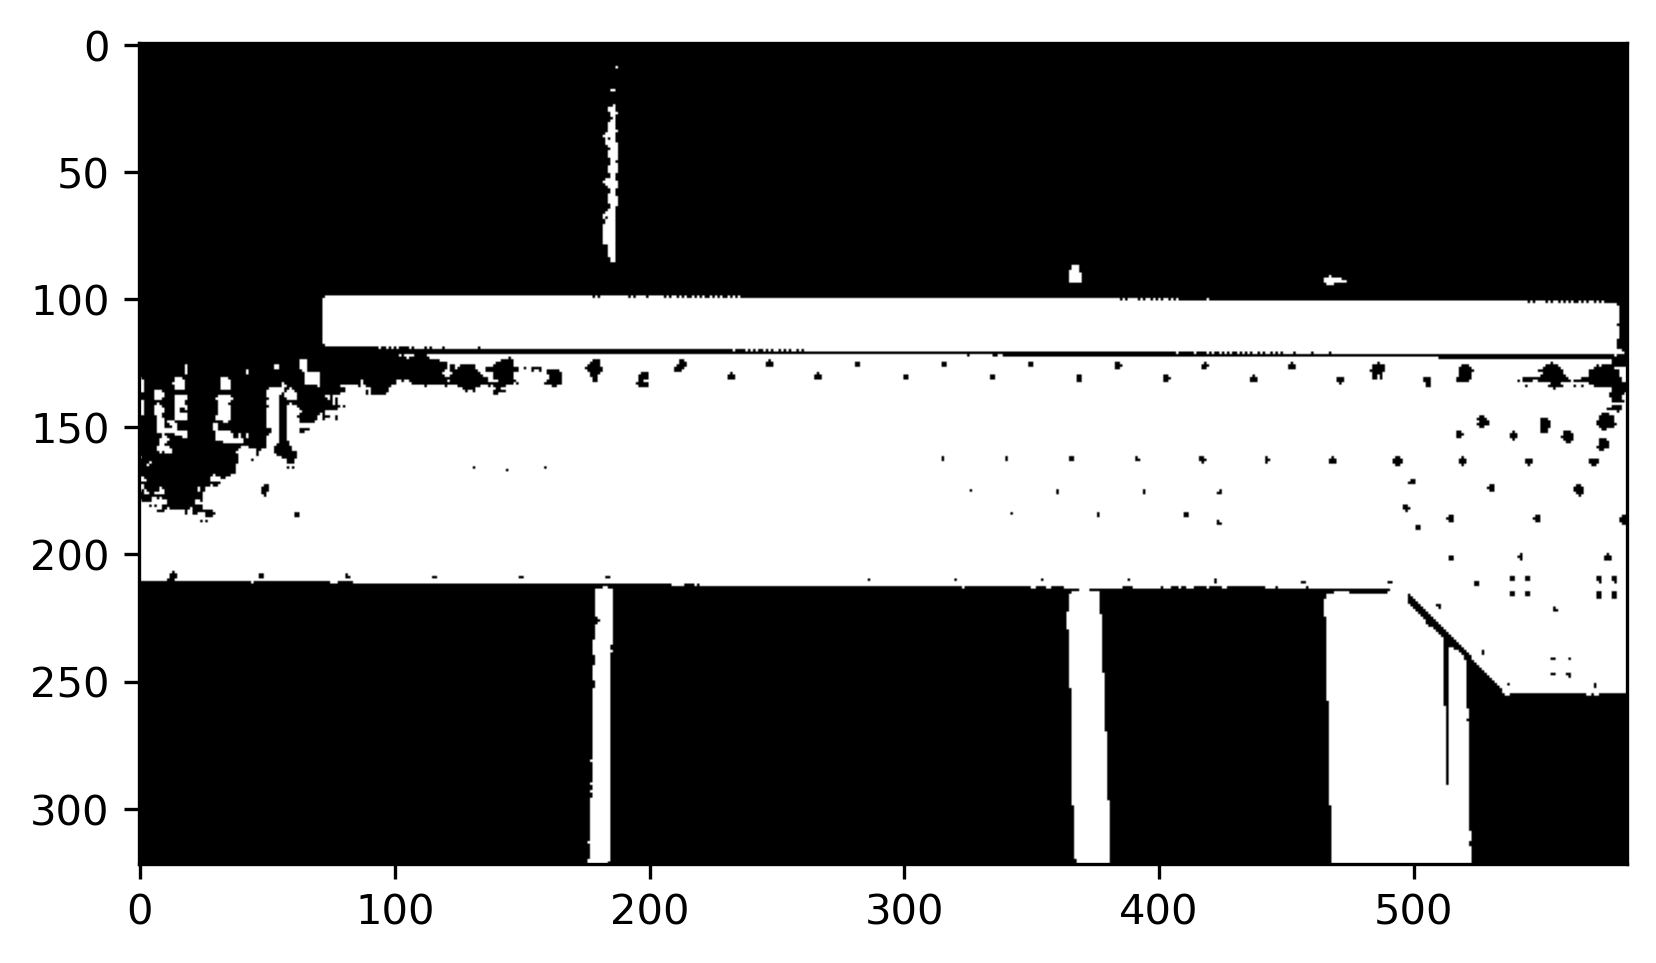

In [112]:
image_gray = cv2.cvtColor(image_pydown[-1], cv2.COLOR_BGR2GRAY)
ret, image_threshold = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# ret, image_thread = cv2.threshold(image_gray, 25, 255, cv2.THRESH_BINARY)
# 应用自适应阈值化，将图像转换为二值图像
# image_threshold = cv2.adaptiveThreshold(image_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 0)
plt.figure(dpi=300)
plt.imshow(image_threshold, 'gray')
plt.show()

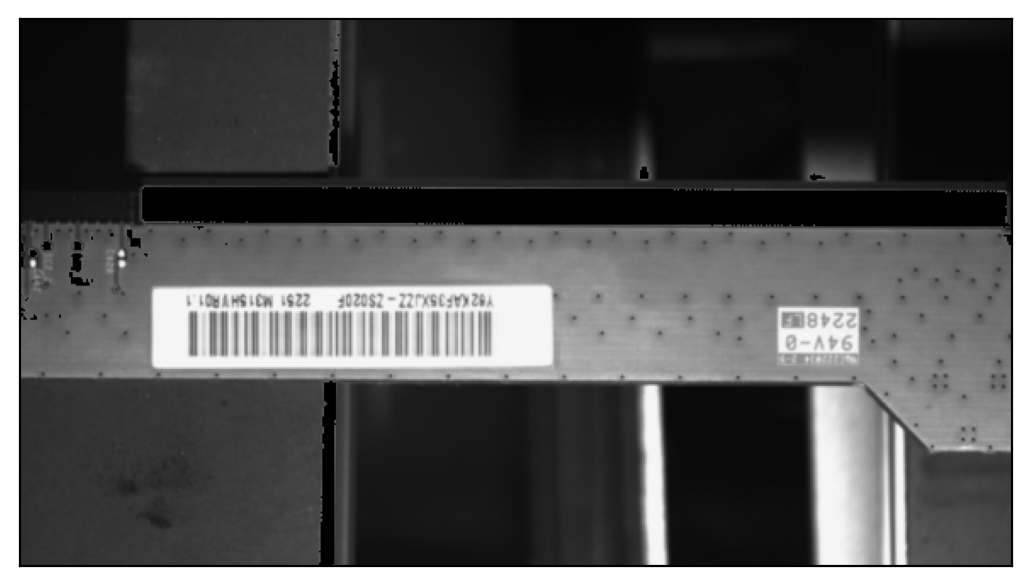

In [116]:
contours, hierarchy = cv2.findContours(image_threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_draw = np.copy(image_pydown[-1])
# image_draw = cv2.drawContours(image_pydown[-1], contours, -1, (0, 255, 0), 1)

lsd = cv2.createLineSegmentDetector()
lines_list = []
for contour in contours:
	x, y, w, h = cv2.boundingRect(contour)

	if cv2.contourArea(contour) > 70:
		# cv2.rectangle(image_draw, (x, y), (x + w, y + h), (0, 0, 255), 1)

		image_gray_part = image_gray[y:y + h, x:x + w]
		# image_threshold1 = cv2.adaptiveThreshold(image_gray_part, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 2*h+1, 0)
		ret1, image_threshold1 = cv2.threshold(image_gray_part, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)
		# detect lines_list
		lines, width, prec, nfa = lsd.detect(image_threshold1)
		try:
			if lines.shape[0] < 70:
				# color = get_rect_corner_ave(image_draw, x, y, w, h)
				cv2.drawContours(image_draw, [contour], -1, 0, cv2.FILLED)
			else:
				for line in lines:
					# 获取线段的起点和终点坐标
					x1, y1, x2, y2 = line[0].astype(int)
					# 绘制线段
					# cv2.line(image_draw, (x + x1, y + y1), (x + x2, y + y2), (0, 255, 0), 2)
		except:
			pass
		lines_list.append(lines)
	else:
		# color = get_rect_corner_ave(image_draw, x, y, w, h)
		cv2.drawContours(image_draw, [contour], -1, 0, cv2.FILLED)
# image_draw = cv2.minAreaRect([contours],(0, 0, 255))
plt.figure(dpi=200)
plt.xticks([])
plt.yticks([])
plt.imshow(cv2.cvtColor(image_draw, cv2.COLOR_BGR2RGB))
plt.show()

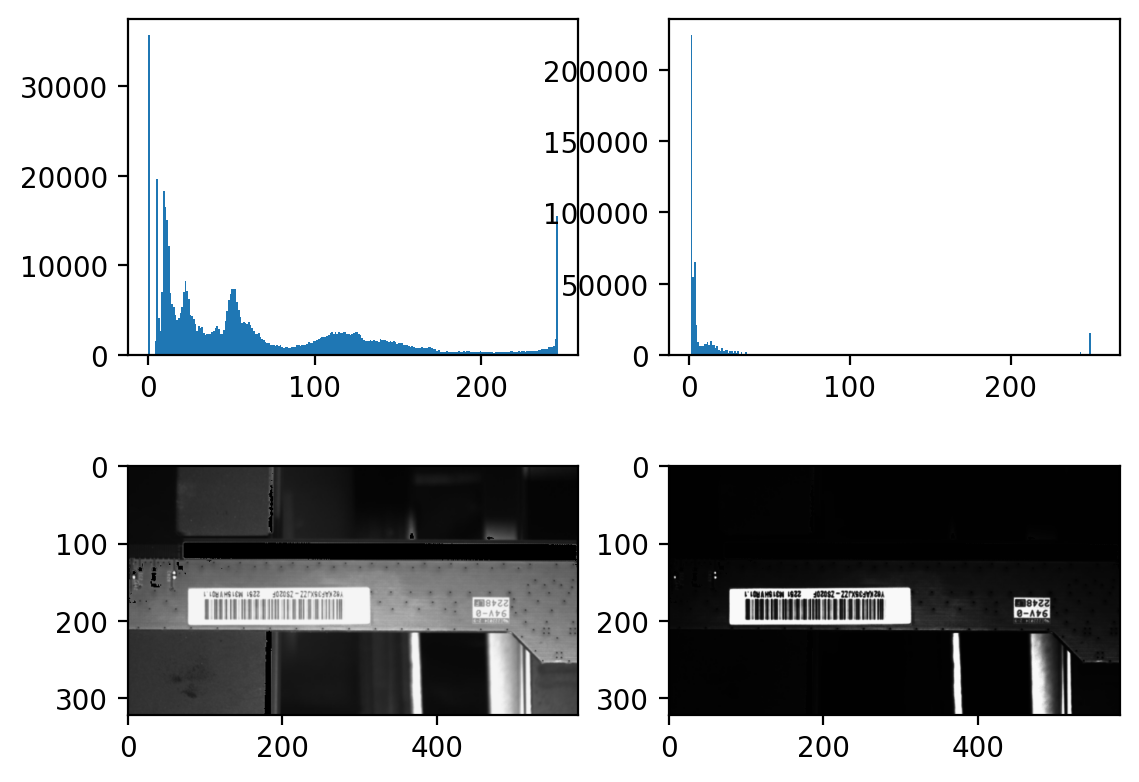

In [114]:
# test_image = cv2.cvtColor(image_draw, cv2.COLOR_BGR2GRAY)
imax = np.max(image_draw)
new_image = (255 ** (image_draw / imax)).astype(np.uint8)
plt.figure(dpi=200)
plt.subplot(2, 2, 1)
plt.hist(image_draw.ravel(), np.max(image_draw), [0, np.max(image_draw)])
plt.subplot(2, 2, 2)
plt.hist(new_image.ravel(), np.max(new_image), [0, np.max(new_image)])

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(image_draw, cv2.COLOR_BGR2RGB))
plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
plt.show()

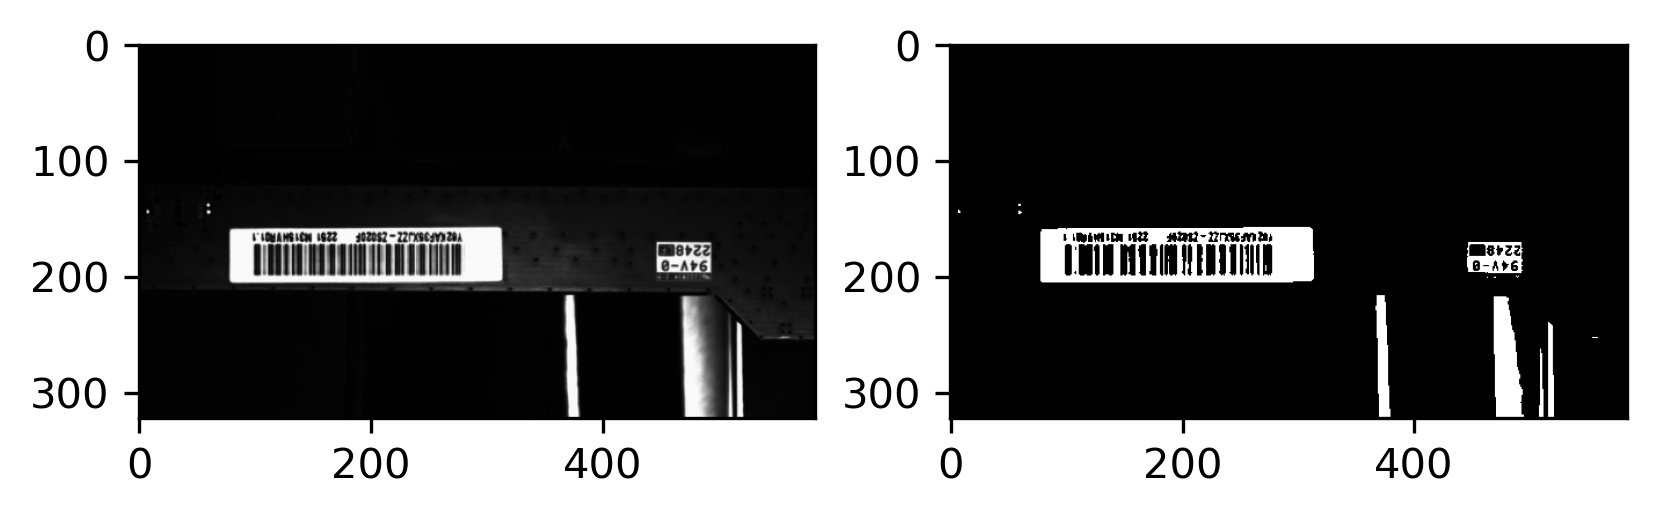

In [115]:
test_gray= cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
r,t= cv2.threshold(test_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.figure(dpi=300)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(t,'gray')
plt.show()

In [ ]:
# Contrast stretching
# equ = cv2.normalize(image_cut, None, 0, 255, cv2.NORM_MINMAX)

# Gamma correction
gamma = np.log(255) / np.log(np.max(image_draw))
equ = np.power(image_draw, gamma).astype(np.uint8)

# 绘制原始图像的灰度直方图和更改分布后的灰度直方图
plt.figure(dpi=200)
plt.subplot(2, 2, 1)
plt.hist(image_draw.ravel(), np.max(image_draw), [0, np.max(image_draw)])
plt.subplot(2, 2, 2)
plt.hist(equ.ravel(), np.max(equ), [0, np.max(equ)])

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(image_draw, cv2.COLOR_BGR2RGB))
plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(equ, cv2.COLOR_BGR2RGB))
plt.show()


In [ ]:
from location.LineCluster import find_barcode_by_cluster, draw_clusters

clusters = find_barcode_by_cluster(equ, 20)
image_drawed = draw_clusters(equ, clusters)
plt.figure(dpi=300)
plt.imshow(cv2.cvtColor(image_drawed, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Adaptive histogram equalization:
# Load the image
path = r'D:\Fenkx\Fenkx - General\AI\Dataset\BarCode\My Datasets\Factory'
result_path = r'C:\Users\fy.xie\Desktop\temp\image_equ'
for index, item in enumerate(os.listdir(path)):
	file = os.path.join(path, item)
	if os.path.isfile(file):
		image_source = cv2.imdecode(np.fromfile(file, dtype=np.uint8), 1)
		try:
			image_pydown = pyrdown_multithread(image_source)
			image_cut = hist_cut(image_pydown[-1], 500)
			gamma = np.log(255) / np.log(np.max(image_cut))
			equ = np.power(image_cut, gamma).astype(np.uint8)
		finally:
			# result_path = os.path.join(path, 'image_equ')
			if not os.path.exists(result_path):
				os.makedirs(result_path)
			cv2.imwrite(os.path.join(result_path, item), equ)
print('finished!')
